In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

In [ ]:
class CTRDataset(Dataset):
    def __init__(self, folder_path, transform=None, ctr_min=0.0, ctr_max=0.27):
        self.folder_path = folder_path
        self.image_files = os.listdir(folder_path)
        self.transform = transform
        self.ctr_min = ctr_min
        self.ctr_max = ctr_max

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        ctr, _, _ = filename.split("_", 2)
        ctr = float(ctr) / 100.0
        ctr = (ctr - self.ctr_min) / (self.ctr_max - self.ctr_min)
        img_path = os.path.join(self.folder_path, filename)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor([ctr], dtype=torch.float32)

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = CTRDataset("filtered_images", transform)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [4]:
model = models.resnet18(pretrained=True)

for name, param in model.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1)
)

C:\Users\benas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.0908, Val Loss: 0.0168, MAE: 0.0910, R²: -0.1021
Epoch 2, Train Loss: 0.0153, Val Loss: 0.0135, MAE: 0.0797, R²: 0.1079
Epoch 3, Train Loss: 0.0141, Val Loss: 0.0120, MAE: 0.0694, R²: 0.2038
Epoch 4, Train Loss: 0.0123, Val Loss: 0.0115, MAE: 0.0693, R²: 0.2364
Epoch 5, Train Loss: 0.0119, Val Loss: 0.0111, MAE: 0.0726, R²: 0.2770
Epoch 6, Train Loss: 0.0111, Val Loss: 0.0115, MAE: 0.0693, R²: 0.2781
Epoch 7, Train Loss: 0.0096, Val Loss: 0.0116, MAE: 0.0699, R²: 0.2615
Epoch 8, Train Loss: 0.0089, Val Loss: 0.0164, MAE: 0.0943, R²: 0.0497
Epoch 9, Train Loss: 0.0097, Val Loss: 0.0119, MAE: 0.0681, R²: 0.2547
Epoch 10, Train Loss: 0.0091, Val Loss: 0.0113, MAE: 0.0645, R²: 0.2563


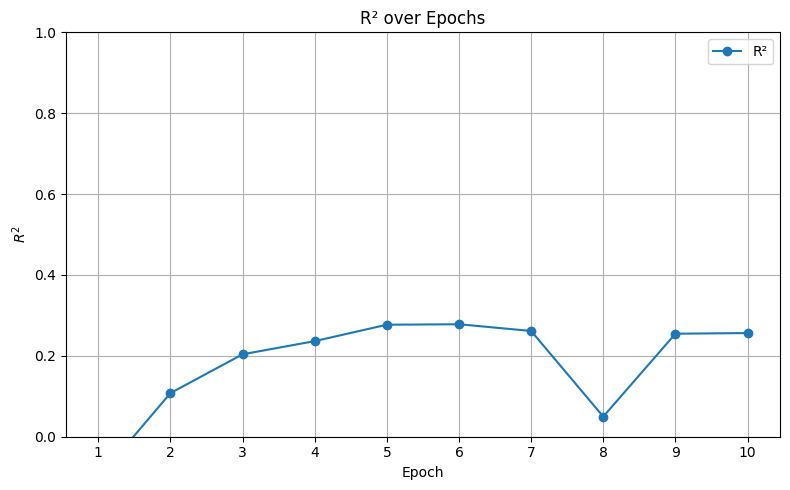

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

r2_scores = []
train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    running_loss = 0
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    r2_scores.append(r2)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Plot R² over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(r2_scores) + 1), r2_scores, marker='o', label='R²')
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.title("R² over Epochs")
plt.grid(True)
plt.xticks(range(1, len(r2_scores) + 1))
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
with open("params.txt", "w") as f:
    for name, param in model.named_parameters():
        f.write(name + "\n")